<a href="https://colab.research.google.com/github/prateekbps/DataScience/blob/main/Corals_classification(CNN%2C_Augmentation%2C_Transfer_Learning_VGG19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d vencerlanz09/healthy-and-bleached-corals-image-classification

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification
License(s): ODbL-1.0
healthy-and-bleached-corals-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_file = zipfile.ZipFile('/content/healthy-and-bleached-corals-image-classification.zip','r')
zip_file.extractall('/content')
zip_file.close()

In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the path to the dataset directory
data_dir = '/content'  # Path to the parent folder containing 'bleached_corals' and 'healthy_corals'

IMG_SIZE = (224, 224)  # Resize images to 128x128

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='training',
    classes=['bleached_corals', 'healthy_corals']
)

# Load the validation data
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation',
    classes=['bleached_corals', 'healthy_corals']
)

# Verify the classes detected
print("Classes detected:", train_data.class_indices)


Found 739 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Classes detected: {'bleached_corals': 0, 'healthy_corals': 1}


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Load VGG19 model with pre-trained weights from ImageNet
vgg19_model = VGG19(
    input_shape=(224, 224, 3),  # Input size (VGG19 expects 224x224 images)
    include_top=False,          # Exclude the fully connected layers on top
    weights="imagenet"          # Use pre-trained weights from ImageNet
)

# Freeze the layers of VGG19 initially
for layer in vgg19_model.layers:
    layer.trainable = False

output = vgg19_model.layers[-1].output

flatten = Flatten()(output)

flatten_bn = BatchNormalization()(flatten)


dense = Dense(64, activation='relu', kernel_regularizer=l2(0.003))(flatten_bn)

dense_dropout = Dropout(0.5)(dense)

output = Dense(1, activation='sigmoid', name='output')(dense_dropout)

model = Model(inputs=vgg19_model.input, outputs=output)

model.summary()

# Compile the model with an optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,730,497 (82.90 MB)

 Trainable params: 1,655,937 (6.32 MB)

 Non-trainable params: 20,074,560 (76.58 MB)

In [8]:
# Callbacks

# EarlyStopping: Stop training if the validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


tensorboard = TensorBoard(
    log_dir='./logs',           # Directory where TensorBoard logs will be saved
    histogram_freq=1,           # Log histograms of weights every epoch
    write_graph=True,           # Log the model graph
    write_images=True           # Log model weights as images
)

# Assuming you already have ImageDataGenerator setup for your data

from sklearn.utils import class_weight


# Calculate class weights
train_labels = train_data.classes

# Compute the class weights based on the labels
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=train_labels
)

# Convert class weights to a dictionary
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    class_weight=class_weight_dict,  # Pass the class weights here
    callbacks=[early_stopping, reduce_lr, tensorboard]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5571 - loss: 1.2481 - val_accuracy: 0.6685 - val_loss: 0.9850 - learning_rate: 1.0000e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 752ms/step - accuracy: 0.6693 - loss: 1.0569 - val_accuracy: 0.6957 - val_loss: 0.9439 - learning_rate: 1.0000e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 676ms/step - accuracy: 0.6879 - loss: 1.0090 - val_accuracy: 0.6522 - val_loss: 0.9613 - learning_rate: 1.0000e-04
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 730ms/step - accuracy: 0.6969 - loss: 0.9652 - val_accuracy: 0.7554 - val_loss: 0.8987 - learning_rate: 1.0000e-04
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - accuracy: 0.7241 - loss: 0.8909 - val_accuracy: 0.7120 - val_loss: 0.9162 - learning_rate: 1.0000e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 683ms/step - accuracy: 0.7712 - loss: 0.8872 - val_accuracy: 0.7500 - val_loss: 0.8886 - learning_rate: 1.0000e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 691ms/step - accuracy: 0.7664 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


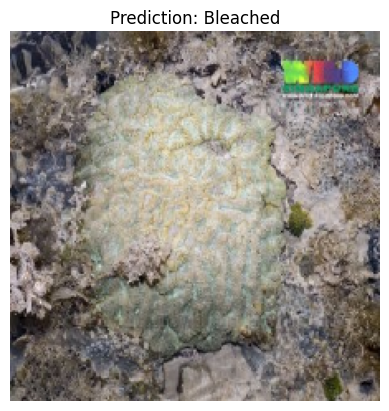

In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the single image
img_path = '/content/bleached_corals/10033870215_3664757d59_o.jpg'  #
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Step 2: Predict the class for the image
predictions = model.predict(img_array)

# Step 3: Display the image and its prediction
class_names = ['Bleached', 'Healthy', ]

plt.imshow(img)
plt.title(f"Prediction: {class_names[np.argmax(predictions)]}")
plt.axis('off')  # Hide axes
plt.show()